# Восстановление золота из руды

**Задача** - подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

- Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 

- Модель должна оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**План:**

1. Подготовить данные и провести предобработку
2. Провести исследовательский анализ данных
3. Построить и обучить модель

In [1]:
import pandas as pd
import glob
from sklearn.metrics import mean_absolute_error 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

sns.set_style("darkgrid")
pd.options.display.float_format = '{:,.2f}'.format
matplotlib.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)


## Подготовка данных

In [2]:
data_set = []
path = '/datasets/'
filenames = glob.glob(path+"gold_recovery*_new.csv")
for  i in filenames:
    data_set.append(pd.read_csv(i))
filenames

['/datasets/gold_recovery_full_new.csv',
 '/datasets/gold_recovery_test_new.csv',
 '/datasets/gold_recovery_train_new.csv']

In [3]:
gold_recovery_full_new = data_set[0]
gold_recovery_test_new = data_set[1]
gold_recovery_train_new = data_set[2]

### Расчет эффективности обогащения 

Рассчитаем эффективноть обогащения на по формуле <br> <br>
$recovery = \dfrac{C*(F-T)}{F*(C-T)}*100$%

- C — доля золота в концентрате после флотации/очистки -`rougher.output.concentrate_au`
- F — доля золота в сырье/концентрате до флотации/очистки - `rougher.input.feed_au`
- T — доля золота в отвальных хвостах после флотации/очистки -`rougher.output.tail_au`

In [4]:
gold_recovery_train_new['recovery_train_calculate'] = (
    (gold_recovery_train_new['rougher.output.concentrate_au']*(gold_recovery_train_new['rougher.input.feed_au']-gold_recovery_train_new['rougher.output.tail_au']))/
    (gold_recovery_train_new['rougher.input.feed_au']*(gold_recovery_train_new['rougher.output.concentrate_au']-gold_recovery_train_new['rougher.output.tail_au']))*100
)

In [5]:
mae = mean_absolute_error (gold_recovery_train_new['rougher.output.recovery'],gold_recovery_train_new['recovery_train_calculate'])
print('Среднее абсолютное отклонение МАЕ - {:.2%}'.format(mae))

Среднее абсолютное отклонение МАЕ - 0.00%


**Вывод:** Отклонений нет, все корректно посчитано

### Оценка нулевых значений

**Комментарий:** В шаге 2 Анализа данных, были выявлены аномальные нулевые значения концентратов металлов, целесообразно заменить данные на средние значения, так как имело быть место потеря данных. Для того чтобы модель обучалась на одинаковых признаках проведем корректироку данных на данном этапе. А на всех этапах, где были нули по концентратам, удалим  значения.

In [6]:
null_concentrate_list = gold_recovery_train_new[['final.output.concentrate_au','primary_cleaner.output.concentrate_au','rougher.output.concentrate_au','rougher.input.feed_au']] [(gold_recovery_train_new ['final.output.concentrate_au']== 0)&(gold_recovery_train_new ['primary_cleaner.output.concentrate_au']== 0)&(gold_recovery_train_new ['final.output.concentrate_au']== 0)].index
gold_recovery_train_new.drop(index = null_concentrate_list, inplace = True)

rougher_output_concentrate_au_list= gold_recovery_train_new[['final.output.concentrate_au','primary_cleaner.output.concentrate_au','rougher.output.concentrate_au','rougher.input.feed_au']][(gold_recovery_train_new ['rougher.output.concentrate_au']== 0)].index
primary_cleaner_output_concentrate_au_list = gold_recovery_train_new[['final.output.concentrate_au','primary_cleaner.output.concentrate_au','rougher.output.concentrate_au','rougher.input.feed_au']][(gold_recovery_train_new ['primary_cleaner.output.concentrate_au']== 0)].index
final_output_concentrate_au_list = gold_recovery_train_new[['final.output.concentrate_au','primary_cleaner.output.concentrate_au','rougher.output.concentrate_au','rougher.input.feed_au']][(gold_recovery_train_new ['final.output.concentrate_au']== 0)].index

gold_recovery_train_new.loc[rougher_output_concentrate_au_list, 'rougher.output.concentrate_au']=gold_recovery_train_new['rougher.output.concentrate_au'].mean()
gold_recovery_train_new.loc[primary_cleaner_output_concentrate_au_list, 'primary_cleaner.output.concentrate_au']=gold_recovery_train_new['primary_cleaner.output.concentrate_au'].mean()
gold_recovery_train_new.loc[final_output_concentrate_au_list, 'final.output.concentrate_au']=gold_recovery_train_new['final.output.concentrate_au'].mean()

### Оценка недоступных данных в тестовой выборке

In [7]:
train_columns = gold_recovery_train_new.columns
test_columns = gold_recovery_test_new.columns
full_columns =gold_recovery_full_new.columns

missing_columns_test = []
for i in range(len(train_columns)):
    if (train_columns[i] not in test_columns and 'output.recovery' not in train_columns[i]):
        missing_columns_test.append(train_columns[i])
# missing_columns_test   # посомтрим какие колонки отсутствуют в тесте, rougher.output.recover, final.output.recovery надо оставить как таргет

**Комментарий:** на всех стадиях отсутствуют  выходные  параметры продуктов по концентратам, хвостов металлов. Исключим эти данные из трэйна шагом ниже. 

In [8]:
data_train = gold_recovery_train_new.drop(columns = missing_columns_test)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14147 entries, 0 to 14148
Data columns (total 55 columns):
date                                          14147 non-null object
final.output.recovery                         14147 non-null float64
primary_cleaner.input.sulfate                 14127 non-null float64
primary_cleaner.input.depressant              14115 non-null float64
primary_cleaner.input.feed_size               14147 non-null float64
primary_cleaner.input.xanthate                14047 non-null float64
primary_cleaner.state.floatbank8_a_air        14143 non-null float64
primary_cleaner.state.floatbank8_a_level      14146 non-null float64
primary_cleaner.state.floatbank8_b_air        14143 non-null float64
primary_cleaner.state.floatbank8_b_level      14146 non-null float64
primary_cleaner.state.floatbank8_c_air        14145 non-null float64
primary_cleaner.state.floatbank8_c_level      14146 non-null float64
primary_cleaner.state.floatbank8_d_air        14144 non-null flo

**Комментарий:** также в тестовой выборке отсутствуют таргеты `rougher.output.recovery` и `final.output.recovery`, добавим из датафрейма `gold_recovery_full_new`. Выполним это действие шагом ниже. 

In [9]:
gold_recovery_test_new = pd.merge(gold_recovery_test_new, gold_recovery_full_new [['date','rougher.output.recovery','final.output.recovery']], how = 'inner', on = 'date')

### Предобратока данных

После изучения датафреймов и условия задачи можно сделать вывод, что соседние по времени параметры часто похожи. Целесообразно заменить пропущенные значения - NaN на соседние.

In [10]:
data_train = data_train.sort_values('date').fillna(method ='ffill')
data_test = gold_recovery_test_new .sort_values('date').fillna(method ='ffill')

## Анализ данных

### Оценка изменения концентрации (Au,Ag,Pb) на всех этапах очистки

In [11]:
data_concentration_metall = gold_recovery_full_new.loc[:,gold_recovery_full_new.columns.isin(missing_columns_test)]

Для простоты поиска создами функцию  для просмотра всех столбцов с  упоминанием метелла, который ищем.

In [12]:
def find_columns(metall,columns):
    metall_list = []
    for i in range(len(columns)):
        if metall in columns[i]:
            metall_list.append(columns[i])
    return metall_list

Выберем необходимые столбцы для оценки изменения  концентраций металлов

In [13]:
columns_list = find_columns('au',full_columns)
columns_list

['final.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_au']

Осуществим выбор и консолидацию данных для простоты использования

In [14]:
df_au = pd.DataFrame(gold_recovery_full_new, columns=['rougher.input.feed_au', 'rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au'])
df_ag = pd.DataFrame(gold_recovery_full_new, columns=['rougher.input.feed_ag', 'rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag'])
df_pb = pd.DataFrame(gold_recovery_full_new, columns=['rougher.input.feed_pb', 'rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb'])
df_au_ag_pb = [df_au,df_ag,df_pb]
#df_au.loc[1]

Построим  графики концентраций  сырья

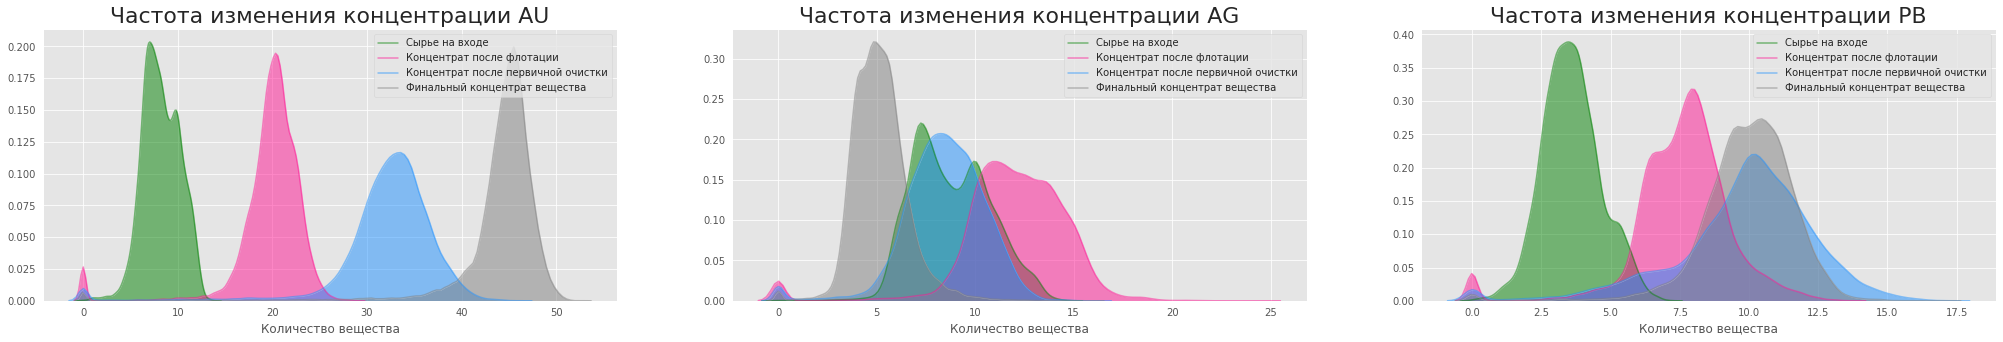

In [15]:
fig, axes = plt.subplots(1, 3,figsize=(35, 5));

title_list = ['Частота изменения концентрации AU','Частота изменения концентрации AG','Частота изменения концентрации PB']
color = ['g','deeppink','dodgerblue','gray']
label = ['Сырье на входе','Концентрат после флотации','Концентрат после первичной очистки','Финальный концентрат вещества']

for i in range(3):
    for j in range(4):
        sns.kdeplot(df_au_ag_pb[i][df_au_ag_pb[i].columns[j]], shade=True, color=color[j], label=label[j], alpha=.5,ax=axes[i])
    axes[i].set_title(title_list[i], fontsize=22)
    axes[i].set_xlabel('Количество вещества')
    axes[i].legend()
plt.show()

**Вывод:** 
- Концентрация золота (AU) увеличивается на каждом этапе это и есть основная задача технологического процесса. 
- Концентрация серебра (AG) снижается после вторичной  очистки и свинца
- Концентрация свинца (PB) становиться практически неизменной после первичной  очистки
- Стоит обратить внимание на нулевые значения концентрата золота после стадий очистки, скорее всего, это аномальные значения. Проанлизировав данные решено заменить на среднее в шаге 1 в блока оценка нулевых значений.

### Оценим распределение размеров гранул сырья на обучающей и тестовой выборках. 

Исходим из того, что если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [16]:
display(find_columns('size',test_columns)) # посмотрим, где есть упоминание size
display(find_columns('size',train_columns))

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

Построим распредления по размеру гранул

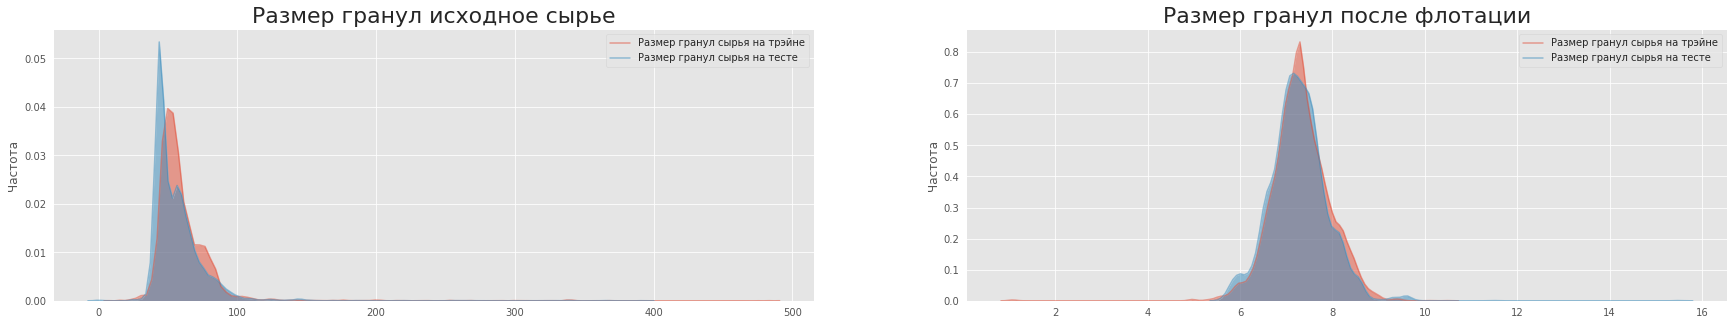

In [17]:
fig, axes = plt.subplots(1, 2,figsize=(30, 5));
title_list = ['Размер гранул исходное сырье','Размер гранул после флотации']
label = ['Размер гранул сырья на трэйне','Размер гранул сырья на тесте']

sns.kdeplot(data_train['rougher.input.feed_size'],alpha=.5,shade=True,ax=axes[0],label=label[0])
sns.kdeplot(data_test['rougher.input.feed_size'],alpha=.5,shade=True,ax=axes[0],label=label[1]) 
axes[0].set_title(title_list[0], fontsize=22)
# axes[0].set_xlim(0, 150)
axes[0].set_ylabel('Частота')
axes[0].set_xlabel(None)
axes[0].legend()

sns.kdeplot(data_train['primary_cleaner.input.feed_size'],alpha=.5,shade=True,ax=axes[1],label=label[0])
sns.kdeplot(data_test['primary_cleaner.input.feed_size'],alpha=.5,shade=True,ax=axes[1],label=label[1])
axes[1].set_title(title_list[1], fontsize=22)
# axes[1].set_xlim(4, 10)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel(None)
axes[1].legend()
plt.show()

**Вывод:** Распределение гранул исходного сырья похоже на нормальное со смещением влево как в обучающей. Размер гранул после  флотации имеет вид нормального распределения. Существует много выбросов после размера гранул 120.



### Оценка суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [18]:
display(find_columns('concentrate',full_columns)) # посмотрим , что есть из концентратов

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

Просуммируем все полученные концентраты на всех этапах

In [19]:
concentrate_metall_df=pd.DataFrame()
concentrate_metall_df['final_output_concentratet_metall']= gold_recovery_full_new['final.output.concentrate_ag']+gold_recovery_full_new['final.output.concentrate_pb']+gold_recovery_full_new['final.output.concentrate_sol']+gold_recovery_full_new['final.output.concentrate_au']
concentrate_metall_df['primary_cleaner_output_metall'] = gold_recovery_full_new['primary_cleaner.output.concentrate_ag']+gold_recovery_full_new['primary_cleaner.output.concentrate_pb']+gold_recovery_full_new['primary_cleaner.output.concentrate_sol']+gold_recovery_full_new['primary_cleaner.output.concentrate_au']
concentrate_metall_df['rougher_output_concentrate_metall']= gold_recovery_full_new['rougher.output.concentrate_ag']+gold_recovery_full_new['rougher.output.concentrate_pb']+gold_recovery_full_new['rougher.output.concentrate_sol']+gold_recovery_full_new['rougher.output.concentrate_au']

Построим график концентраций всех веществ на  разнчх стадиях

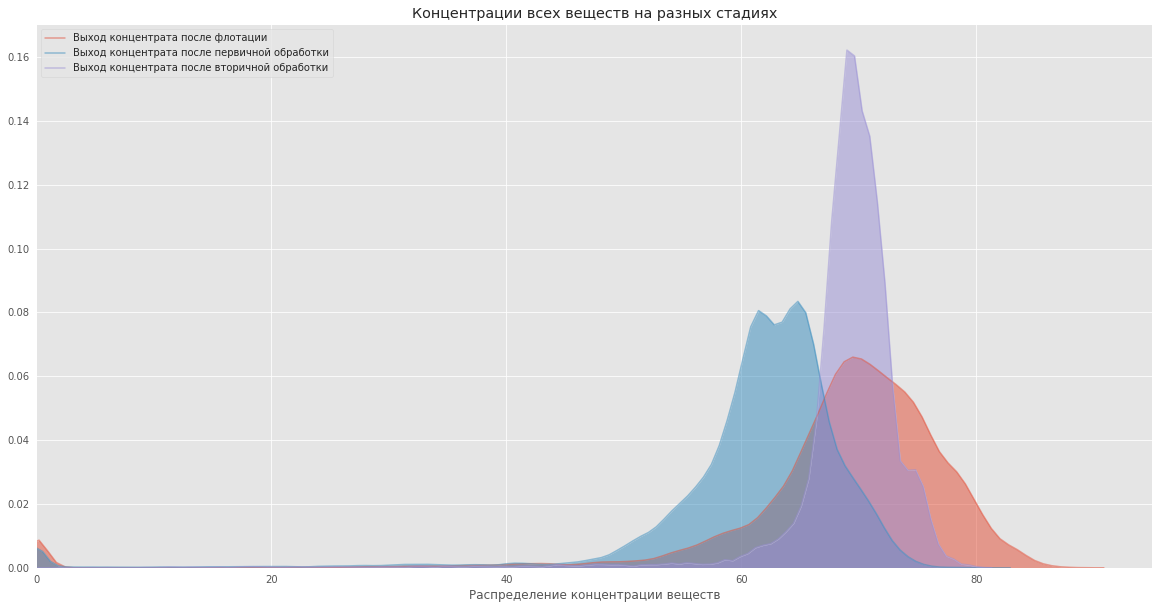

In [20]:
plt.figure(figsize=(20,10))
sns.kdeplot(concentrate_metall_df['rougher_output_concentrate_metall'],alpha=0.5,shade=True,label = 'Выход концентрата после флотации')
sns.kdeplot(concentrate_metall_df['primary_cleaner_output_metall'],alpha=0.5,shade=True, label = 'Выход концентрата после первичной обработки')
sns.kdeplot(concentrate_metall_df['final_output_concentratet_metall'],alpha=0.5,shade=True, label = 'Выход концентрата после вторичной обработки')
plt.xlim(0, 95)
plt.legend()
plt.title("Концентрации всех веществ на разных стадиях")
plt.xlabel('Распределение концентрации веществ')
plt.show()

**Вывод:**  по результатам оценки данных были выявлены отсутстующие значения - NAN и нулевые значения.
- нулевые значения были заменены на средние соответствующие значения, записаны в трейн 
- отсутстующие значения NAN были заменены на соседние значения, записаны в трейн 

## Модель

### Сформируем обучающую и целевые выборки

Выделим целевые векторы

In [21]:
data_target_rougher = data_train['rougher.output.recovery']
data_target_final = data_train['final.output.recovery']
data_target_rougher_test = data_test['rougher.output.recovery']
data_target_final_test = data_test['final.output.recovery']

data_features_train = data_train.drop(['date','final.output.recovery','rougher.output.recovery'],axis =1)
data_features_test = data_test.drop(['date','final.output.recovery','rougher.output.recovery'],axis =1) 

In [22]:
data_test.columns


Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

### Создание функции для вычисления итогового sMAPE

- sMAPE расчитаем по формуле.

$sMAPE = \frac 1n \sum_{i=1}^n \frac{|y_i-y_i^{predict}|}{(|y_i|-|y_i^{predict}|)*\left( \frac12 \right)}*100$%  <br>

 - Итоговое sMAPE расчитаем по формуле:<br><br> $Итоговое SMAPE = 0.25*sMAPE(rougher) + 0.75*sMAPE(final)$

### Масштабирование данных

Так как будем работать с линейной моделью и признаки имеют разный масштаб, то требуется масштабировать данные.

In [23]:
scaler_ffeatures_train = StandardScaler()
scaler_data_features_test = StandardScaler()

scaler_ffeatures_train.fit(data_features_train)
scaler_data_features_test.fit(data_features_test)

data_features_test = scaler_data_features_test.transform(data_features_test)
data_features_train = scaler_ffeatures_train.transform(data_features_train)


Создадим функцию метрики sMAPE

In [24]:
def smape(target,predict):# функция  расчета  smae
    target= pd.Series(target)
    predict = pd.Series(predict)
    
    n= target.shape[0]
    
    smape=  (
        (((target-predict).abs())/ 
        (((target).abs()+(predict).abs())/2)).sum()
        /n
                    )
    return smape

###  LinearRegression - линейная  регрессия

In [25]:
model_rougher = LinearRegression().fit(data_features_train, data_target_rougher)
predictions_rougher = model_rougher.predict(data_features_train)

model_final = LinearRegression().fit(data_features_train, data_target_final)
predictions_final = model_final.predict(data_features_train)

itog_smape = 0.25 * smape(data_target_rougher,predictions_rougher)+0.75*smape(data_target_final,predictions_final)

print ('Итоговый sMAPE: {:.2%}'.format(itog_smape))

Итоговый sMAPE: 9.38%


Создадим кастомный скорер

In [26]:
smape_scorer = make_scorer(smape,greater_is_better=False)
smape_scorer

make_scorer(smape, greater_is_better=False)

Проверим качество модели кросс-валидацией.

In [27]:
smape_linear_regression_rougher = cross_val_score(model_rougher, data_features_train, np.array(data_target_final),cv=5, scoring = smape_scorer).mean()
smape_linear_regression_final = cross_val_score(model_final,data_features_train, np.array(data_target_final), cv=5, scoring = smape_scorer).mean()
smape_linear_regression_CV = 0.25 *smape_linear_regression_rougher + 0.75 * smape_linear_regression_rougher
print ('Итоговая метрика sMAPE: {:.2%}'.format(-1*smape_linear_regression_CV))


Итоговая метрика sMAPE: 12.18%


### RandomForestRegressor - случайный лес

In [28]:
model_rougher_rfr = RandomForestRegressor(random_state=393,n_estimators=10,max_depth=1)
model_rougher_rfr.fit(data_features_train, data_target_rougher) 
predictions_rougher_rfr  = model_rougher_rfr.predict(data_features_train)

model_final_rfr = RandomForestRegressor(random_state=393,n_estimators=10,max_depth=1)
model_final_rfr.fit(data_features_train, data_target_final) 
predictions_final_rfr  = model_final_rfr.predict(data_features_train)

itog_smape_rfr = 0.25 * smape(data_target_rougher,predictions_rougher_rfr)+0.75*smape(data_target_final,predictions_final_rfr)
print ('Итоговый sMAPE: {:.2%}'.format(itog_smape_rfr))

Итоговый sMAPE: 10.46%


Составим словарь для поиска лучших параметров модели

In [29]:
parametrs = { 'n_estimators': range (10, 50, 10),
              'max_depth': range (1,10, 5)}

In [30]:
%%time
clf = RandomForestRegressor(random_state= 393)
grid = GridSearchCV(clf, parametrs, cv=4,scoring =smape_scorer )
grid.fit(data_features_train, np.array(data_target_rougher))
grid.best_params_

CPU times: user 1min 38s, sys: 0 ns, total: 1min 38s
Wall time: 1min 38s


{'max_depth': 6, 'n_estimators': 40}

In [31]:
%%time
clf = RandomForestRegressor(random_state= 393)
grid2 = GridSearchCV(clf, parametrs, cv=4,scoring =smape_scorer)
grid2.fit(data_features_train, np.array(data_target_final))
grid2.best_params_

CPU times: user 1min 34s, sys: 90.6 ms, total: 1min 34s
Wall time: 1min 35s


{'max_depth': 6, 'n_estimators': 30}

In [32]:
model_rougher_rfr = RandomForestRegressor(random_state=393,n_estimators=60,max_depth=8)
model_rougher_rfr.fit(data_features_train, data_target_rougher) 
predictions_rougher_rfr  = model_rougher_rfr.predict(data_features_train)

model_final_rfr = RandomForestRegressor(random_state=393,n_estimators=40,max_depth=8)
model_final_rfr.fit(data_features_train, data_target_final) 
predictions_final_rfr  = model_final_rfr.predict(data_features_train)

itog_smape_rfr = 0.25 * smape(data_target_rougher,predictions_rougher_rfr)+0.75*smape(data_target_final,predictions_final_rfr)
print ('Итоговый sMAPE: {:.2%}'.format(itog_smape_rfr))

Итоговый sMAPE: 8.18%


### Оценка лучшей модели. Проверка  на тестовой выборке. 

Наилучшие показатели метрики sMAPE показывает модель RandomForestRegressor. Проведем оценку на тестовой  выборке с  подобранными параметрами.

In [33]:
model_rougher_rfr = RandomForestRegressor(random_state=393,n_estimators=50,max_depth=6)
model_rougher_rfr.fit(data_features_train, data_target_rougher) 
predictions_rougher_rfr  = model_rougher_rfr.predict(data_features_test)

model_final_rfr = RandomForestRegressor(random_state=393,n_estimators=30,max_depth=6)
model_final_rfr.fit(data_features_train, data_target_final) 
predictions_final_rfr  = model_final_rfr.predict(data_features_test)

itog_smape_rfr = 0.25 * smape(data_target_rougher,predictions_rougher_rfr)+0.75*smape(data_target_final,predictions_final_rfr)
print ('Итоговый sMAPE: {:.2%}'.format(itog_smape_rfr))

Итоговый sMAPE: 4.50%


**Вывод:** на тестовой выборке результаты метрики, чуть лучше, чем на трейне.

### Оценка качества модели. Сравнение с константной моделью. 

Проведем сравнение с констатной моделью. В  качестве константы используем медианные значение 

In [34]:
dummy_regressor_rougher = DummyRegressor(strategy="median")
dummy_regressor_rougher.fit(data_features_train, data_target_rougher)
dummy_rougher_pred = dummy_regressor_rougher.predict(data_features_test)

dummy_regressor_final = DummyRegressor(strategy="median")
dummy_regressor_final.fit(data_features_train, data_target_final)
dummy_final_pred = dummy_regressor_final.predict(data_features_test)

itog_smape_median= 0.25 * smape(data_target_rougher, dummy_rougher_pred)+0.75*smape(data_target_final,dummy_final_pred)

print('Итоговый sMAPE константной модели: {:.2%}'.format(itog_smape_median)) 

Итоговый sMAPE константной модели: 4.02%


# Итоговый вывод: 

- По результатам проделанной работы рассмотрены  две модели  линейной  регресии и случайный лес. 
- Наиболее лучшая оценочная метрика sMAPE пока зала модель RandomForestRegressor - 4.51%
- Сравненние с константной моделью, значение целевой метрики sMAPE проигрывает на 0.5 . Константная модель выглядит адекватнее выбранной, "Увы и ах".

